# Graph Neural Networks with PyG on Node Classification

In [71]:
%%capture
import torch
version = torch.__version__
i = version.find('+')
version = version[:i-1] + '0' + version[i:]
url = 'https://data.pyg.org/whl/torch-' + version + '.html'

!uv pip install torch-scatter -f $url
!uv pip install torch-sparse -f $url
!uv pip install torch-cluster -f $url

!uv pip install torch-geometric
!uv pip install pygod
!uv pip install --upgrade scipy

In [72]:
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T

import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
import pandas as pd
import collections

print("All packages installed successfully.")

All packages installed successfully.


In [73]:
def set_seed(random_seed = 42):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)

set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Cora Dataset

In [74]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

### Nodes and Edges

* The Cora dataset contains 2708 papers, which are represented as nodes in the graph.

* The papers in the Cora dataset have 5429 citation connections, which are represented as edges in the graph. The edge information is unique to graph data.

In [75]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')

Number of nodes: 2708
Number of edges: 10556


* Investigating why the number of edges is twice as large as 5429.

In [76]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Has isolated nodes: False
Has self-loops: False
Is undirected: True


* Why is the number of edges twice as larg as the number of citations?
  * From the above cell, there are no nodes not connected by edges, no self-loops, and edges are not directional.
  * This means that the edge count is double the actual count because of the bi-directional edge information included.

* Looking at how edge information is stored using the 30th node as an example.
  * Data is obtained in the form of pairs of nodes to which the edges are connected.

In [77]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]]
edge_example

(2, 10556)


array([[  30,   30,   30,   30,   30,   30],
       [ 697,  738, 1358, 1416, 2162, 2343]])

* Visualizing a network centered on this node.

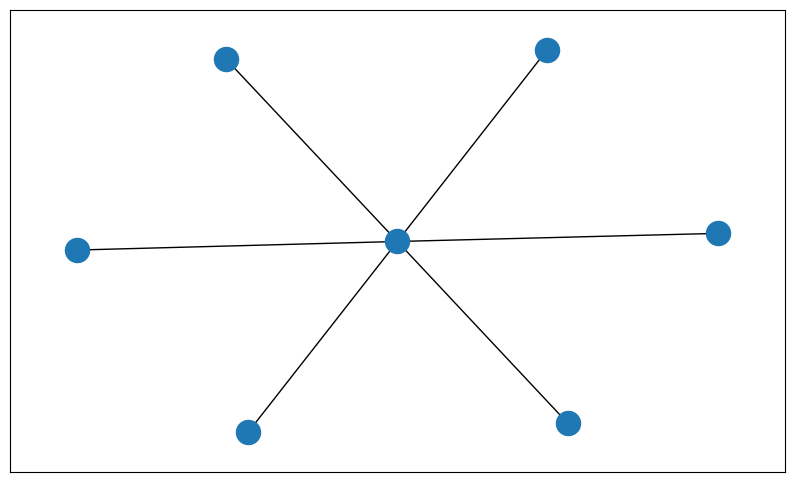

In [78]:
node_example = np.unique(edge_example.flatten())
plt.figure(figsize=(10, 6))
G = nx.Graph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example[0], edge_example[1])))
nx.draw_networkx(G, with_labels=False)

#### Node Degree
* Degree in graph theory means the number of edges joining a vertex (node) in a graph.

In [79]:
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

Average node degree: 3.90


* The average node degree is 3.9.
* The overall distribution can be shown using a histogram of the degree.
  * A high degree means that they are connected to many nodes (papers). In other words, nodes with high degrees are likely to be important. 
  * The number of citations shows how good or bad a paper is.

,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


2708
10556


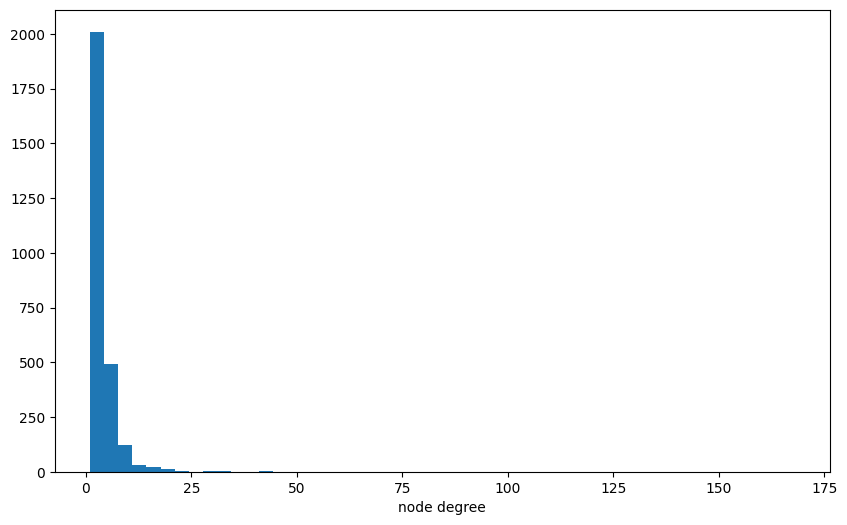

In [80]:
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

* Plotting a graph to see where the top 10 nodes with the highest degree are located.
* The top 10 nodes with the highest degree are represented by yellow dots, and the other nodes are represented by gray dots.
* The yellow dots are proportional to the size of the degree and are all located in the central part of the network.

threshold 0.011821204285186553


/pvc-data/workspaces/tan_en_yao/all-assignments/assignment10/.venv/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:1438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


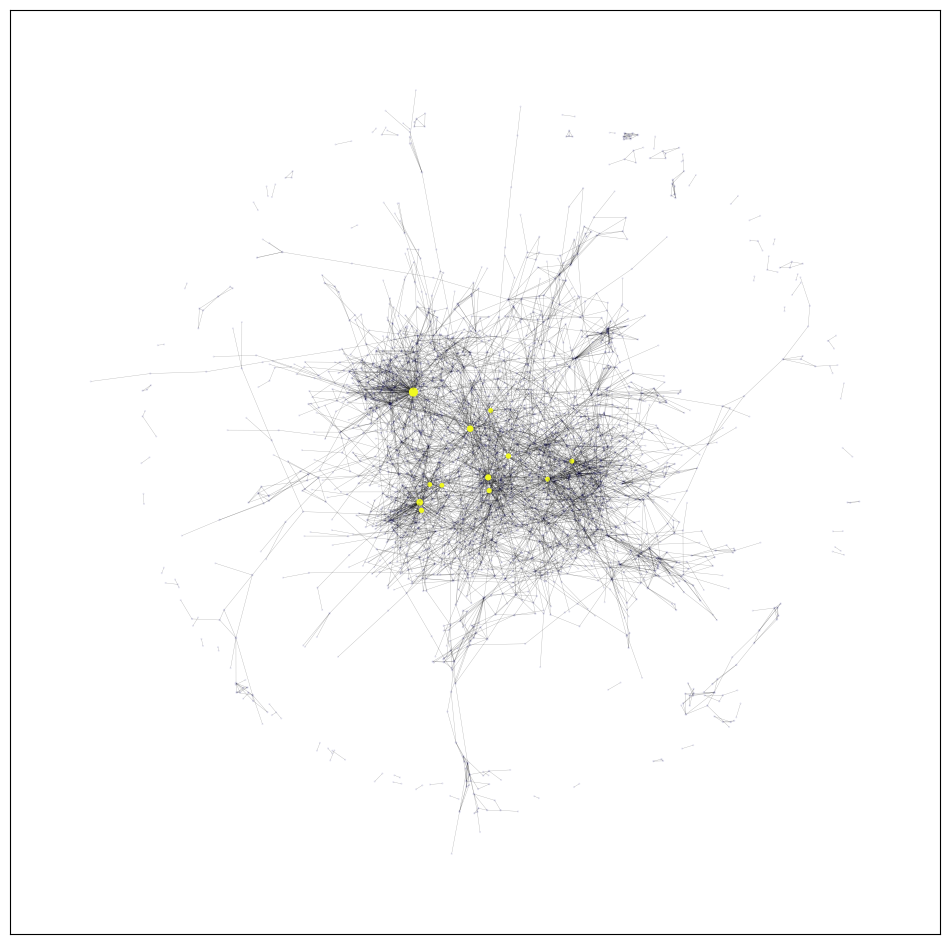

In [81]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
    cmap=plt.cm.plasma,
    node_color=cent_bin,
    nodelist=list(cent.keys()),
    alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

### Features

* The papers in the Cora dataset have 1433 features.
* For each of the 1433 words, the number of features is expressed as 0 and 1 if the word is included or not included in the paper.

In [82]:
print(f'Number of features: {data.num_node_features}')

Number of features: 1433


* Displaying some of the features shows that they are composed of 0s and 1s.

In [83]:
print(len(data.x[0]))
data.x[0][:20]

1433


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1.])

* Data structures to use as model input

In [84]:
data.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [85]:
data.edge_index

tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

* Edges may also have feature values (edge features), but they are not included in the Cora dataset.

In [86]:
print(f'Number of edge features: {data.num_edge_features}')

Number of edge features: 0


### Classes

* The papers in the Cora dataset are labeled with 7 different labels.

In [87]:
print(f'Number of classes: {dataset.num_classes}')

Number of classes: 7


In [88]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}
data.y[:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

* Plotting the class distribution shows that there is an imbalance in the classes

{np.int64(3): 818, np.int64(4): 426, np.int64(0): 351, np.int64(2): 418, np.int64(1): 217, np.int64(5): 298, np.int64(6): 180}


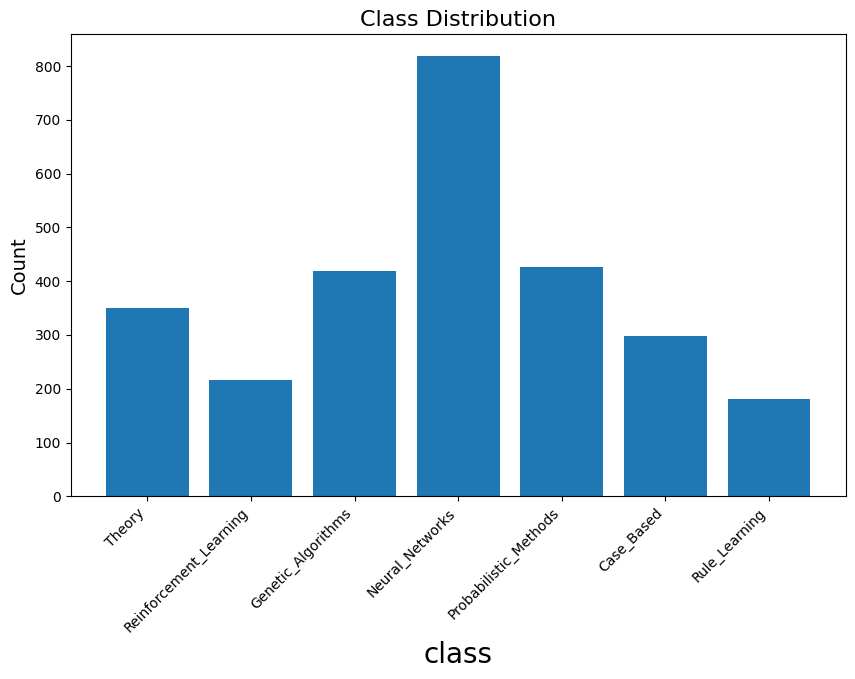

In [89]:
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)

plt.ylabel("Count", size=14)
plt.title("Class Distribution", size=16)
plt.xticks(ticks=range(7), labels=[label_dict[i] for i in range(7)], rotation=45, ha='right')

plt.show()

* Visualizing the class within the Cora graph
* Using the spring layout, nodes repel each other like charged particles, while edges act like springs, pulling connected nodes together.
* This results in natural clustering as publications within the same research field tend to cite each other frequently

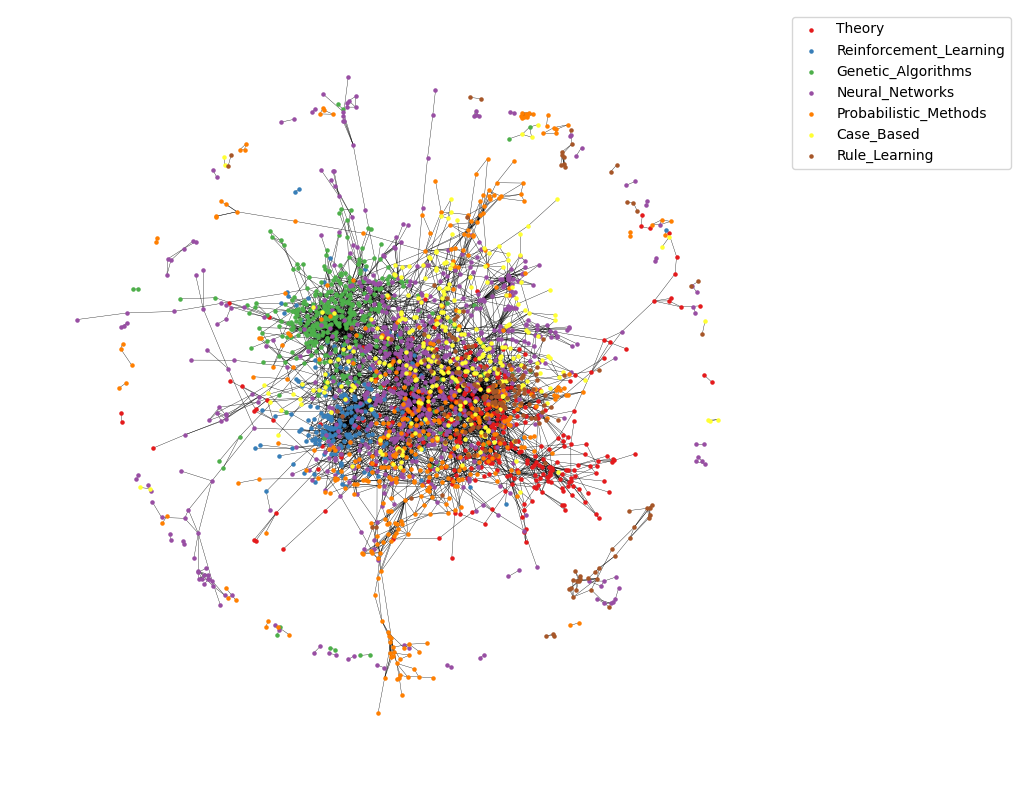

In [90]:
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
labels = data.y.numpy()

# Group nodes by class
class_nodes = {i: [] for i in range(7)}
for idx, label in enumerate(labels):
    class_nodes[label].append(idx)

# Plot
plt.figure(figsize=(10, 10))
for class_id, nodes in class_nodes.items():
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=5,
                           node_color=colorlist[class_id],
                           label=label_dict[class_id])
nx.draw_networkx_edges(G, pos, width=0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.axis("off")
plt.show()

## Training a Graph Convolutional Network (GCN)

### Splitting the data

* PyG only implements the `RandomNodeSplit`, which is commonly used for benchmarking purposes.
* Here, stratified sampling is employed instead to account for class imbalance.

In [91]:
# split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
# graph = split(data)  # resetting data split
# print(
#     f"train: {int(graph.train_mask.sum())}, ",
#     f"val: {int(graph.val_mask.sum())}, ",
#     f"test: {int(graph.test_mask.sum())}",
# )

from sklearn.model_selection import train_test_split

# Get labels
labels = data.y.cpu().numpy()
num_nodes = len(labels)

# First split: Train vs (Val + Test)
train_idx, rest_idx = train_test_split(
    range(num_nodes),
    train_size=0.7,
    stratify=labels,
    random_state=42
)

# Second split: Val vs Test (from remaining nodes)
val_labels = labels[rest_idx]
val_idx, test_idx = train_test_split(
    rest_idx,
    train_size=0.5,
    stratify=val_labels,
    random_state=42
)

# Create boolean masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

# Assign to graph
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Print split sizes
print(
    f"train: {int(train_mask.sum())}, ",
    f"val: {int(val_mask.sum())}, ",
    f"test: {int(test_mask.sum())}"
)


train: 1895,  val: 406,  test: 407


### Defining the Model Architecture

* Define a 2-layer model architecture adapted from the [original GCN paper](https://arxiv.org/pdf/1609.02907).

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*muTtylabqtMei2KyGLkgcw.png)

In [92]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(
            dataset.num_node_features, 16
        )
        self.conv2 = GCNConv(
            16, dataset.num_classes
        )
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output

In [93]:
from sklearn.metrics import f1_score

def train_node_classifier(model, graph, optimizer, criterion, n_epochs=100):
    train_losses = []
    val_losses = []
    val_f1_scores = []

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        train_loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        model.eval()
        with torch.no_grad():
            out = model(graph)
            val_loss = criterion(out[graph.val_mask], graph.y[graph.val_mask])
            preds = out[graph.val_mask].argmax(dim=1).cpu().numpy()
            targets = graph.y[graph.val_mask].cpu().numpy()
            val_f1 = eval_node_classifier(model, graph, graph.val_mask)

        val_losses.append(val_loss.item())
        val_f1_scores.append(val_f1)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, Val F1: {val_f1:.3f}')

    # Plot training and validation loss
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss', color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Plot validation accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, n_epochs + 1), val_f1_scores, label='Validation F1 Score', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Validation F1 Score over Epochs")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return model


def eval_node_classifier(model, graph, mask):
    model.eval()
    with torch.no_grad():
        preds = model(graph).argmax(dim=1).cpu().numpy()
        targets = graph.y[mask].cpu().numpy()

    f1 = f1_score(targets, preds[mask.cpu().numpy()], average='macro', zero_division=0)
    return f1

Epoch: 010, Train Loss: 1.040, Val Loss: 1.039, Val F1: 0.679
Epoch: 020, Train Loss: 0.453, Val Loss: 0.533, Val F1: 0.865
Epoch: 030, Train Loss: 0.259, Val Loss: 0.387, Val F1: 0.865
Epoch: 040, Train Loss: 0.191, Val Loss: 0.367, Val F1: 0.858
Epoch: 050, Train Loss: 0.159, Val Loss: 0.371, Val F1: 0.869
Epoch: 060, Train Loss: 0.142, Val Loss: 0.376, Val F1: 0.870
Epoch: 070, Train Loss: 0.131, Val Loss: 0.379, Val F1: 0.875


Epoch: 080, Train Loss: 0.122, Val Loss: 0.384, Val F1: 0.877
Epoch: 090, Train Loss: 0.114, Val Loss: 0.390, Val F1: 0.880
Epoch: 100, Train Loss: 0.107, Val Loss: 0.395, Val F1: 0.880


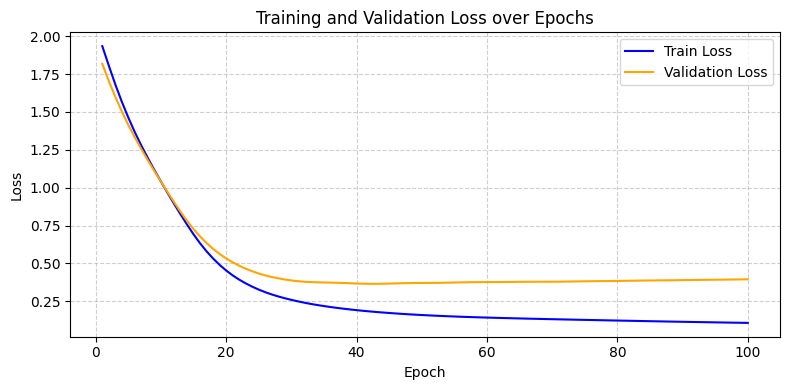

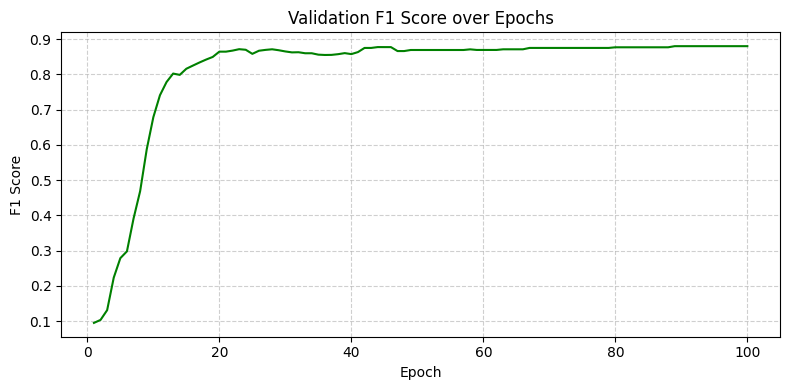

In [94]:
import torch.nn as nn

gcn = GCN().to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

gcn = train_node_classifier(gcn, data, optimizer_gcn, criterion)

### Evaluating the model

* Metrics chosen are F1 score, confusion matrix and ROC AUC because of the class imbalance.
* Evaluation on the test set demonstrates strong performance across all classes, despite class imbalance.

In [95]:
test_f1 = eval_node_classifier(gcn, data, data.test_mask)
print(f'Test F1: {test_f1:.3f}')

Test F1: 0.894


In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

def plot_confusion_matrix(model, graph, mask, label_dict=None):
    model.eval()
    with torch.no_grad():
        logits = model(graph)
        preds = logits.argmax(dim=1)

    y_true = graph.y[mask].cpu().numpy()
    y_pred = preds[mask].cpu().numpy()

    cm = confusion_matrix(y_true, y_pred)

    if label_dict is not None:
        # Sort labels by key to match confusion matrix order
        class_names = [label_dict[i] for i in sorted(label_dict.keys())]
    else:
        class_names = None

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', colorbar=True)
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return cm

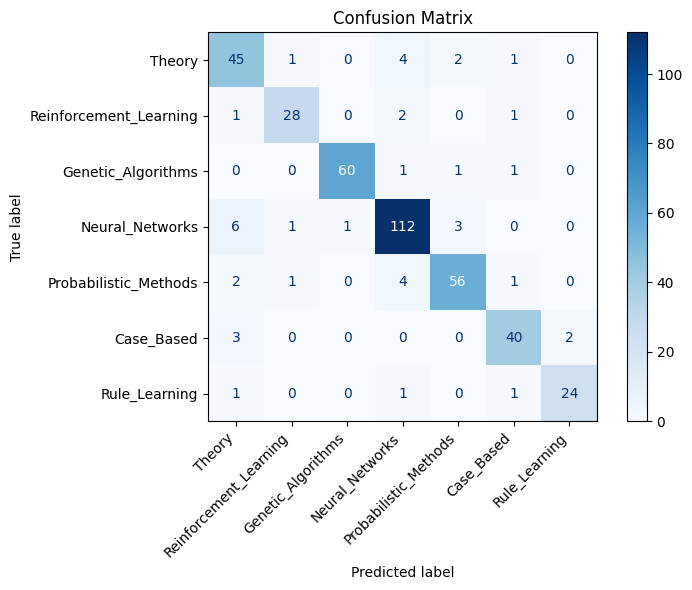

array([[ 45,   1,   0,   4,   2,   1,   0],
       [  1,  28,   0,   2,   0,   1,   0],
       [  0,   0,  60,   1,   1,   1,   0],
       [  6,   1,   1, 112,   3,   0,   0],
       [  2,   1,   0,   4,  56,   1,   0],
       [  3,   0,   0,   0,   0,  40,   2],
       [  1,   0,   0,   1,   0,   1,  24]])

In [97]:
plot_confusion_matrix(gcn, data, data.test_mask, label_dict=label_dict)

In [98]:
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc_auc(y_true, y_score, label_dict=None, title='Multiclass ROC AUC'):
    classes = sorted(label_dict.keys())
    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = y_true_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    if label_dict is not None:
        class_names = [label_dict[c] for c in classes]
    else:
        class_names = [str(c) for c in classes]

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

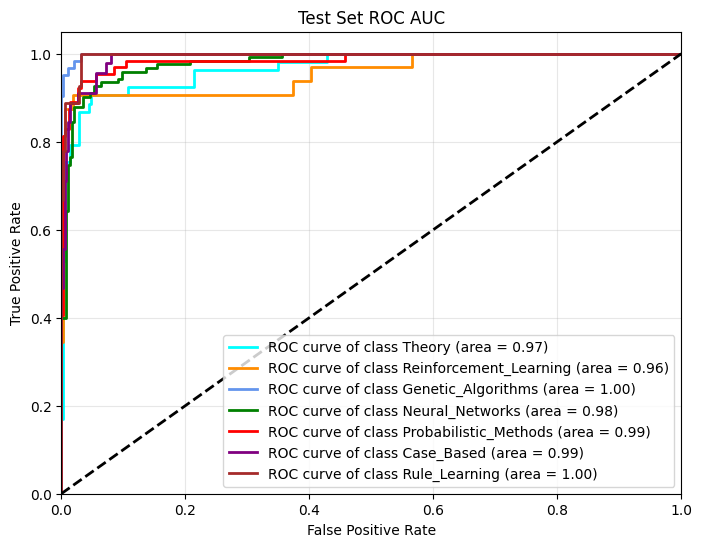

In [99]:
gcn.eval()
with torch.no_grad():
    logits = gcn(data)
    probs = torch.softmax(logits, dim=1)
    y_score = probs[data.test_mask].cpu().numpy()
    y_true = data.y[data.test_mask].cpu().numpy()

classes = sorted(label_dict.keys())
plot_multiclass_roc_auc(y_true, y_score, label_dict=label_dict, title='Test Set ROC AUC')